In [1]:
# Import necessary libraries
import sys
import os

sys.path.append(os.path.abspath('../scripts'))

In [2]:

from data_clean_prep import (
    load_data, check_missing_values, handle_missing_store_data, 
    detect_outliers_iqr, detect_outliers_zscore, add_date_features, 
    add_weekend_flag, clean_store_data,
)

In [3]:
train = load_data('../data/train.csv', parse_dates=['Date'])
test = load_data('../data/test.csv', parse_dates=['Date'])
store = load_data('../data/store.csv') 


2024-09-24 13:48:49,152 - INFO - Loading data from ../data/train.csv...


c:\kifiya-week4\scripts\data_clean_prep.py:22: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, parse_dates=parse_dates)


2024-09-24 13:48:50,175 - INFO - Data loaded with shape (1017209, 9)
2024-09-24 13:48:50,176 - INFO - Loading data from ../data/test.csv...
2024-09-24 13:48:50,235 - INFO - Data loaded with shape (41088, 8)
2024-09-24 13:48:50,237 - INFO - Loading data from ../data/store.csv...
2024-09-24 13:48:50,253 - INFO - Data loaded with shape (1115, 10)


In [4]:
# Check for missing values
check_missing_values(train, 'Train')
check_missing_values(test, 'Test')
check_missing_values(store, 'Store')

2024-09-24 13:48:52,536 - INFO - Checking for missing values in Train...
2024-09-24 13:48:52,599 - INFO - No missing values found in Train.
2024-09-24 13:48:52,600 - INFO - Checking for missing values in Test...
2024-09-24 13:48:52,607 - INFO - Missing values in Test: Open    11
dtype: int64
2024-09-24 13:48:52,608 - INFO - Checking for missing values in Store...
2024-09-24 13:48:52,610 - INFO - Missing values in Store: CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib
from datetime import datetime

def preprocess_data(train, test, store):
    # Merge store information with train and test datasets
    train = train.merge(store, on='Store', how='left')
    test = test.merge(store, on='Store', how='left')

    # Fill missing values for CompetitionDistance and others
    train['CompetitionDistance'].fillna(train['CompetitionDistance'].max(), inplace=True)
    test['CompetitionDistance'].fillna(test['CompetitionDistance'].max(), inplace=True)

    # Fill remaining NaN values with 0
    train.fillna(0, inplace=True)
    test.fillna(0, inplace=True)

    # Convert 'Date' column to datetime format
    train['Date'] = pd.to_datetime(train['Date'])
    test['Date'] = pd.to_datetime(test['Date'])

    # Extract features from the date
    for df in [train, test]:
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Day'] = df['Date'].dt.day
        df['WeekOfYear'] = df['Date'].dt.isocalendar().week
        df['IsWeekend'] = (df['Date'].dt.dayofweek >= 5).astype(int)

        # Days to/from holidays (example for Christmas)
        df['DaysToHoliday'] = (df['Date'] - pd.to_datetime(df['Year'].astype(str) + '-12-25')).dt.days
        df['DaysAfterHoliday'] = (pd.to_datetime(df['Year'].astype(str) + '-12-25') - df['Date']).dt.days

        # Month-related features
        df['IsBeginningOfMonth'] = (df['Day'] <= 10).astype(int)
        df['IsMidMonth'] = df['Day'].between(11, 20).astype(int)
        df['IsEndOfMonth'] = (df['Day'] > 20).astype(int)
        
        # Additional features can be extracted here

    # Prepare the feature matrix and target variable
    X = train.drop(['Sales', 'Date', 'Store'], axis=1)  # Drop irrelevant columns
    y = train['Sales']

    return X, y, test

# Preprocess the data
X, y, test = preprocess_data(train, test, store)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing for numeric and categorical features
numeric_features = ['CompetitionDistance', 'DaysToHoliday', 'DaysAfterHoliday', 'Year', 'Month', 'Day', 'WeekOfYear', 'IsWeekend', 'IsBeginningOfMonth', 'IsMidMonth', 'IsEndOfMonth']
categorical_features = ['StoreType', 'Promo']  # Ensure these are defined correctly

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Define the pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on validation set
y_pred = pipeline.predict(X_val)

# Calculate Mean Squared Error
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)
def get_feature_names(pipeline):
    # Extract numeric features
    numeric_features = pipeline.named_steps['preprocessor'].transformers_[0][2]
    
    # Extract the one-hot encoded feature names
    onehot_encoder = pipeline.named_steps['preprocessor'].transformers_[1][1]
    categorical_features = pipeline.named_steps['preprocessor'].transformers_[1][2]
    
    # Get the feature names for one-hot encoded columns
    onehot_feature_names = onehot_encoder.get_feature_names_out(categorical_features)
    
    # Combine numeric and one-hot encoded feature names
    feature_names = list(numeric_features) + list(onehot_feature_names)
    
    return feature_names

# Call this function after fitting the pipeline
pipeline.fit(X_train, y_train)
feature_names = get_feature_names(pipeline)
print("Expected feature names:", feature_names)


C:\Users\Akram 1\AppData\Local\Temp\ipykernel_5736\738851327.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['CompetitionDistance'].fillna(train['CompetitionDistance'].max(), inplace=True)
C:\Users\Akram 1\AppData\Local\Temp\ipykernel_5736\738851327.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

Mean Squared Error: 6137540.300738267
Expected feature names: ['CompetitionDistance', 'DaysToHoliday', 'DaysAfterHoliday', 'Year', 'Month', 'Day', 'WeekOfYear', 'IsWeekend', 'IsBeginningOfMonth', 'IsMidMonth', 'IsEndOfMonth', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Promo_0', 'Promo_1']


In [6]:
import os
from datetime import datetime
import joblib

# Ensure the 'model' folder exists
model_dir = "../model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Serialize the model with a timestamped filename
timestamp = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
model_filename = f"sales_model_{timestamp}.pkl"
model_filepath = os.path.join(model_dir, model_filename)

joblib.dump(pipeline, model_filepath)

print(f"Model saved in {model_filepath}")
print(f"Model saved as {model_filename}")

Model saved in ../model\sales_model_09-24-2024-14-23-26.pkl
Model saved as sales_model_09-24-2024-14-23-26.pkl


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib
from datetime import datetime

def preprocess_data(train, test, store):
    # Merge store information with train and test datasets
    train = train.merge(store, on='Store', how='left')
    test = test.merge(store, on='Store', how='left')

    # Fill missing values for CompetitionDistance and others
    train['CompetitionDistance'].fillna(train['CompetitionDistance'].max(), inplace=True)
    test['CompetitionDistance'].fillna(test['CompetitionDistance'].max(), inplace=True)

    # Fill remaining NaN values with 0
    train.fillna(0, inplace=True)
    test.fillna(0, inplace=True)

    # Convert 'Date' column to datetime format
    train['Date'] = pd.to_datetime(train['Date'])
    test['Date'] = pd.to_datetime(test['Date'])

    # Extract features from the date
    for df in [train, test]:
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Day'] = df['Date'].dt.day
        df['WeekOfYear'] = df['Date'].dt.isocalendar().week
        df['IsWeekend'] = (df['Date'].dt.dayofweek >= 5).astype(int)

        # Days to/from holidays (example for Christmas)
        df['DaysToHoliday'] = (df['Date'] - pd.to_datetime(df['Year'].astype(str) + '-12-25')).dt.days
        df['DaysAfterHoliday'] = (pd.to_datetime(df['Year'].astype(str) + '-12-25') - df['Date']).dt.days

        # Month-related features
        df['IsBeginningOfMonth'] = (df['Day'] <= 10).astype(int)
        df['IsMidMonth'] = df['Day'].between(11, 20).astype(int)
        df['IsEndOfMonth'] = (df['Day'] > 20).astype(int)
        
        # Additional features can be extracted here

    # Prepare the feature matrix and target variable
    X = train.drop(['Sales', 'Date', 'Store'], axis=1)  # Drop irrelevant columns
    y = train['Sales']

    return X, y, test

# Preprocess the data
X, y, test = preprocess_data(train, test, store)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing for numeric and categorical features
numeric_features = ['CompetitionDistance', 'DaysToHoliday', 'DaysAfterHoliday', 'Year', 'Month', 'Day', 'WeekOfYear', 'IsWeekend', 'IsBeginningOfMonth', 'IsMidMonth', 'IsEndOfMonth']
categorical_features = ['StoreType', 'Promo']  # Ensure these are defined correctly

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Define the pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on validation set
y_pred = pipeline.predict(X_val)

# Calculate Mean Squared Error
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

# Serialize the model
timestamp = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
model_filename = f"sales_model_{timestamp}.pkl"
joblib.dump(pipeline, model_filename)

print(f"Model saved as {model_filename}")


In [10]:
test

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Year,Month,Day,WeekOfYear,IsWeekend,DaysToHoliday,DaysAfterHoliday,IsBeginningOfMonth,IsMidMonth,IsEndOfMonth
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,...,2015,9,17,38,0,-99,99,0,1,0
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,...,2015,9,17,38,0,-99,99,0,1,0
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,...,2015,9,17,38,0,-99,99,0,1,0
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,...,2015,9,17,38,0,-99,99,0,1,0
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,...,2015,9,17,38,0,-99,99,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,...,2015,8,1,31,1,-146,146,1,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,...,2015,8,1,31,1,-146,146,1,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,...,2015,8,1,31,1,-146,146,1,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,...,2015,8,1,31,1,-146,146,1,0,0


In [11]:
# Preprocess the new test data
X_test = test.drop(['Date', 'Store'], axis=1)  # Drop irrelevant columns for test

# Predict sales on the test data
predictions = pipeline.predict(X_test)

# Store predictions in the test DataFrame
test['PredictedSales'] = predictions

# Display relevant information
print(test[['Store', 'Date', 'PredictedSales']])


       Store       Date  PredictedSales
0          1 2015-09-17     5049.390000
1          3 2015-09-17     7608.950000
2          7 2015-09-17     9461.060000
3          8 2015-09-17     6078.152000
4          9 2015-09-17     5298.877083
...      ...        ...             ...
41083   1111 2015-08-01     2426.220833
41084   1112 2015-08-01     5193.420000
41085   1113 2015-08-01     3337.118000
41086   1114 2015-08-01     4142.094667
41087   1115 2015-08-01     3867.500000

[41088 rows x 3 columns]


In [ ]:
submission = test[['Store', 'PredictedSales']].copy()

# Rename columns to match the submission format
submission.columns = ['Id', 'Sales']

# Save to CSV file
submission.to_csv('submission.csv', index=False)

# Verify by printing the first few rows
print(submission.head())

                Feature  Importance
0   CompetitionDistance    0.277701
16              Promo_1    0.117857
15              Promo_0    0.104585
2      DaysAfterHoliday    0.087748
1         DaysToHoliday    0.086929
5                   Day    0.084881
7             IsWeekend    0.073432
3                  Year    0.062883
6            WeekOfYear    0.026815
12          StoreType_b    0.024138
4                 Month    0.016468
11          StoreType_a    0.010498
13          StoreType_c    0.008670
14          StoreType_d    0.008614
9            IsMidMonth    0.004461
10         IsEndOfMonth    0.002695
8    IsBeginningOfMonth    0.001626


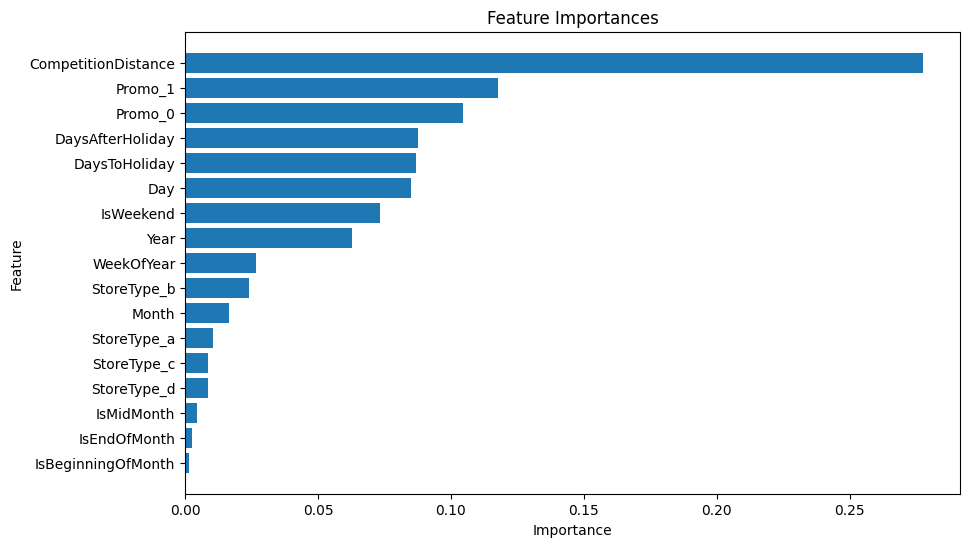

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming the previous code is executed and the model pipeline is already fit

# Get feature names after one-hot encoding
# OneHotEncoder generates multiple columns for each category, so we need to capture those
categorical_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine numeric and categorical feature names
all_feature_names = np.concatenate([numeric_features, categorical_feature_names])

# Extract the RandomForestRegressor from the pipeline and get feature importances
rf_model = pipeline.named_steps['model']
feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the DataFrame
print(feature_importance_df)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


ADF Statistic: -9.483218625441102
p-value: 3.823201819195913e-16
The time series is stationary.


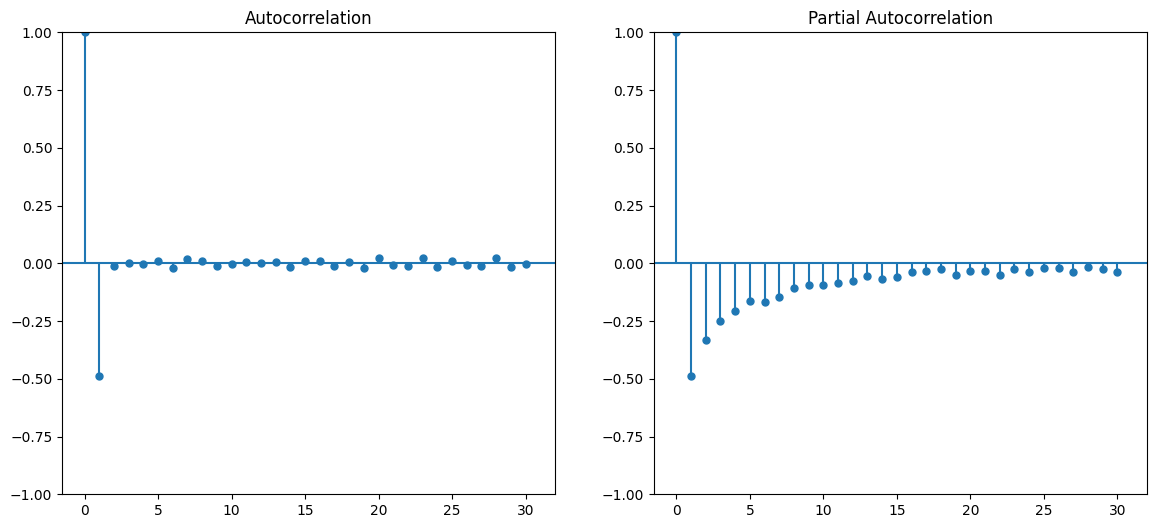

c:\kifiya-week4\myvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 30 and 1 for '{{node sequential_1/lstm_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1/lstm_1/strided_slice_2, sequential_1/lstm_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [?,30], [1,200].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(None, 30), dtype=float32)
  • states=('tf.Tensor(shape=(None, 50), dtype=float32)', 'tf.Tensor(shape=(None, 50), dtype=float32)')
  • training=True

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Check if the time series data is stationary
def check_stationarity_optimized(timeseries):
    # Perform ADF test with a smaller maxlag and no autolag to save memory
    adf_test = adfuller(timeseries, maxlag=10, autolag=None)
    print(f"ADF Statistic: {adf_test[0]}")
    print(f"p-value: {adf_test[1]}")
    
    if adf_test[1] < 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary, consider differencing.")

# 2. Differencing the time series data if non-stationary
def difference_data(df, column, lag=1):
    df[f'{column}_diff'] = df[column].diff(lag)
    return df.dropna()

# 3. Autocorrelation and Partial Autocorrelation
def plot_acf_pacf(data, lags=30):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    plot_acf(data, lags=lags, ax=ax[0])
    plot_pacf(data, lags=lags, ax=ax[1])
    plt.show()

# 4. Create Sliding Window for LSTM
def create_sliding_window(df, target_col, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df.iloc[i:i + window_size].values)
        y.append(df.iloc[i + window_size])
    return np.array(X), np.array(y)

# 5. Data Generator for LSTM
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, labels, batch_size=32, window_size=30):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.window_size = window_size
        self.indices = np.arange(len(self.data) - window_size)

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X, y = self.__data_generation(batch_indices)
        return X, y

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

    def __data_generation(self, batch_indices):
        X = []
        y = []
        for i in batch_indices:
            X.append(self.data[i:i + self.window_size])
            y.append(self.labels[i + self.window_size])
        return np.array(X), np.array(y)

# Load your dataset
# Example: train = pd.read_csv('your_data.csv') 
# For this example, assuming 'train' is already defined

# Assuming 'train' contains sales data for time series analysis
sales_data = train[['Date', 'Sales']].set_index('Date').sort_index()

# Use a subset of the data for checking stationarity
subset_sales_data = sales_data.head(1000)  # Adjust the size if necessary
check_stationarity_optimized(subset_sales_data['Sales'])

# If not stationary, difference the data
sales_data = difference_data(sales_data, 'Sales')

# Plot ACF and PACF
plot_acf_pacf(sales_data['Sales_diff'].dropna())

# Prepare data for LSTM
window_size = 30  # Predict based on the last 30 days
X, y = create_sliding_window(sales_data[['Sales_diff']], 'Sales_diff', window_size)

# Scale the data into the (-1, 1) range
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

# Split data into training and validation sets
split = int(0.8 * len(X_scaled))
X_train, X_val = X_scaled[:split], X_scaled[split:]
y_train, y_val = y_scaled[:split], y_scaled[split:]

# Use the DataGenerator for LSTM training
train_data_gen = DataGenerator(X_train, y_train, batch_size=32, window_size=window_size)

# Define LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(window_size, X_train.shape[2])),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model using the generator
model.fit(train_data_gen, epochs=20)

# Predicting future sales on validation set (you might need to adapt this)
y_pred = model.predict(X_val)

# Inverse transform to get actual sales values
y_pred_actual = scaler.inverse_transform(y_pred)

# Optionally, visualize predictions
plt.figure(figsize=(14, 6))
plt.plot(y_val, label='Actual Sales')
plt.plot(y_pred_actual, label='Predicted Sales', alpha=0.7)
plt.legend()
plt.show()


ADF Statistic: -9.483218625441102
p-value: 3.823201819195913e-16
The time series is stationary.


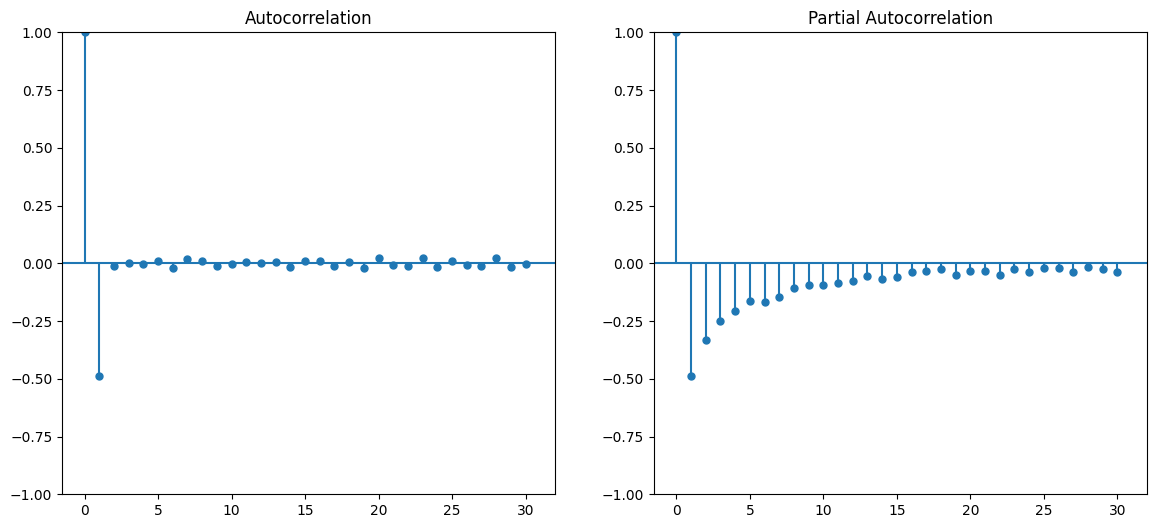

Epoch 1/20


c:\kifiya-week4\myvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 30 and 1 for '{{node sequential_1_1/lstm_1_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1_1/lstm_1_1/strided_slice_2, sequential_1_1/lstm_1_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [?,30], [1,200].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(None, 30), dtype=float32)
  • states=('tf.Tensor(shape=(None, 50), dtype=float32)', 'tf.Tensor(shape=(None, 50), dtype=float32)')
  • training=True

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Check if the time series data is stationary
def check_stationarity_optimized(timeseries):
    adf_test = adfuller(timeseries, maxlag=10, autolag=None)
    print(f"ADF Statistic: {adf_test[0]}")
    print(f"p-value: {adf_test[1]}")
    if adf_test[1] < 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary, consider differencing.")

# 2. Differencing the time series data if non-stationary
def difference_data(df, column, lag=1):
    df[f'{column}_diff'] = df[column].diff(lag)
    return df.dropna()

# 3. Autocorrelation and Partial Autocorrelation
def plot_acf_pacf(data, lags=30):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    plot_acf(data, lags=lags, ax=ax[0])
    plot_pacf(data, lags=lags, ax=ax[1])
    plt.show()

# 4. Create Sliding Window for LSTM
def create_sliding_window(df, target_col, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df.iloc[i:i + window_size].values)
        y.append(df.iloc[i + window_size].values[0])  # Get the target value directly
    return np.array(X), np.array(y)

# 5. Data Generator for LSTM
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, labels, batch_size=32, window_size=30):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.window_size = window_size
        self.indices = np.arange(len(self.data) - window_size)

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X, y = self.__data_generation(batch_indices)
        return X, y

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

    def __data_generation(self, batch_indices):
        X = []
        y = []
        for i in batch_indices:
            X.append(self.data[i:i + self.window_size])
            y.append(self.labels[i + self.window_size])
        return np.array(X), np.array(y)

# Load your dataset
# Example: train = pd.read_csv('your_data.csv') 
# For this example, assuming 'train' is already defined

# Assuming 'train' contains sales data for time series analysis
sales_data = train[['Date', 'Sales']].set_index('Date').sort_index()

# Use a subset of the data for checking stationarity
subset_sales_data = sales_data.head(1000)  # Adjust the size if necessary
check_stationarity_optimized(subset_sales_data['Sales'])

# If not stationary, difference the data
sales_data = difference_data(sales_data, 'Sales')

# Plot ACF and PACF
plot_acf_pacf(sales_data['Sales_diff'].dropna())

# Prepare data for LSTM
window_size = 30  # Predict based on the last 30 days
X, y = create_sliding_window(sales_data[['Sales_diff']], 'Sales_diff', window_size)

# Reshape the data to add the third dimension (1 feature)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Scale the data into the (-1, 1) range
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

# Split data into training and validation sets
split = int(0.8 * len(X_scaled))
X_train, X_val = X_scaled[:split], X_scaled[split:]
y_train, y_val = y_scaled[:split], y_scaled[split:]

# Use the DataGenerator for LSTM training
train_data_gen = DataGenerator(X_train, y_train, batch_size=32, window_size=window_size)

# Define LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(window_size, 1)),  # Correct input shape
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model using the generator
model.fit(train_data_gen, epochs=20)

# Predicting future sales on validation set (you might need to adapt this)
y_pred = model.predict(X_val)

# Inverse transform to get actual sales values
y_pred_actual = scaler.inverse_transform(y_pred)

# Optionally, visualize predictions
plt.figure(figsize=(14, 6))
plt.plot(y_val, label='Actual Sales')
plt.plot(y_pred_actual, label='Predicted Sales', alpha=0.7)
plt.legend()
plt.show()
